## Load the Dataset

In [2]:
import pandas as pd

df = pd.read_csv("../data/togo-dapaong_qc.csv")  
print(f"Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Data loaded successfully!
Dataset shape: (525600, 19)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


## Summary Statistics & Missing-Value Report

In [3]:
df.describe(include='all')
df.isna().sum()

missing_cols = df.columns[df.isna().mean() > 0.05]
print("Columns with >5% missing:", missing_cols.tolist())


Columns with >5% missing: ['Comments']


## Outlier Detection & Cleaning

In [5]:
from scipy import stats
import numpy as np

cols_to_check = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
available_cols = [col for col in cols_to_check if col in df.columns]

# Calculate Z-scores
z_scores = np.abs(stats.zscore(df[available_cols], nan_policy='omit'))

# Create Cleaning_flag BEFORE cleaning
df_clean = df.copy()
df_clean['Cleaning_flag'] = 'clean'  # Initialize all as clean

# Flag outliers
outlier_mask = (z_scores > 3).any(axis=1)
df_clean.loc[outlier_mask, 'Cleaning_flag'] = 'outlier'

print(f"Outliers detected: {outlier_mask.sum()}")

# Impute missing values with median and flag them
for col in available_cols:
    missing_mask = df_clean[col].isna()
    if missing_mask.any():
        df_clean.loc[missing_mask, 'Cleaning_flag'] = 'imputed'
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Optional: Remove outliers instead of just flagging them
# df_clean = df_clean[~outlier_mask]  # Uncomment this to actually remove outliers

print("Cleaning flag distribution:")
print(df_clean['Cleaning_flag'].value_counts())



Outliers detected: 9251
Cleaning flag distribution:
Cleaning_flag
clean      516349
outlier      9251
Name: count, dtype: int64


## Time Series Analysis

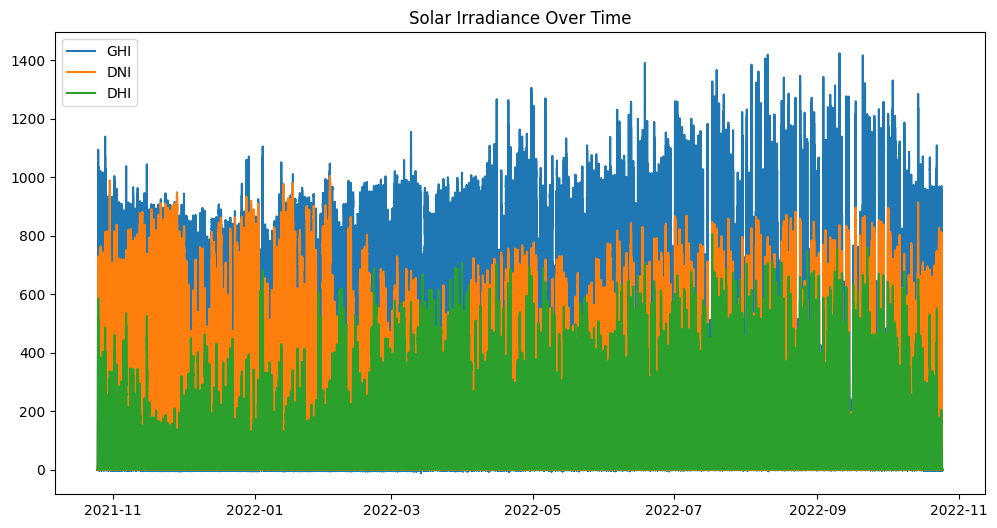

In [6]:
import matplotlib.pyplot as plt

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
plt.figure(figsize=(12,6))
plt.plot(df["Timestamp"], df["GHI"], label="GHI")
plt.plot(df["Timestamp"], df["DNI"], label="DNI")
plt.plot(df["Timestamp"], df["DHI"], label="DHI")
plt.legend(); plt.title("Solar Irradiance Over Time")
plt.show()


Group by month:

<Axes: xlabel='Month'>

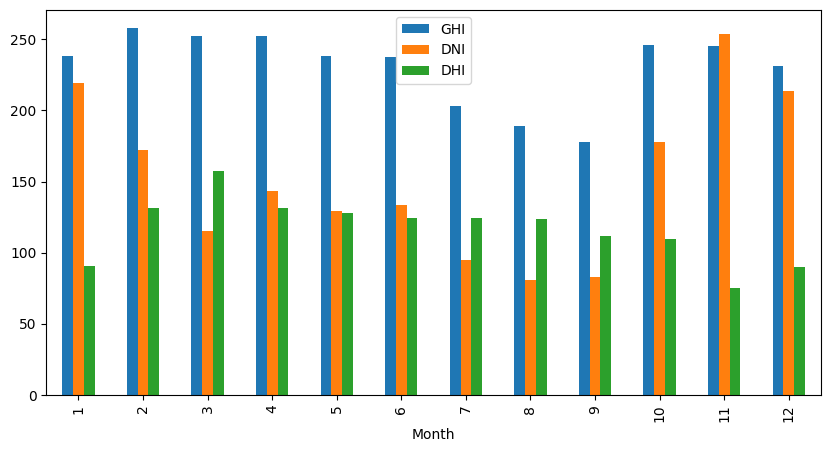

In [7]:
df["Month"] = df["Timestamp"].dt.month
df.groupby("Month")[["GHI", "DNI", "DHI"]].mean().plot(kind="bar", figsize=(10,5))


## Cleaning Impact

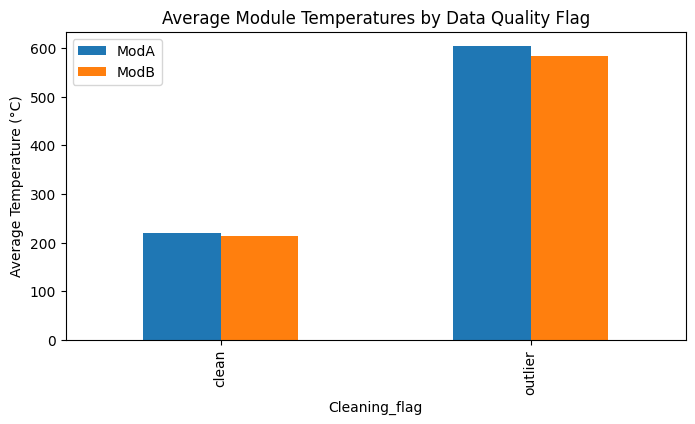

In [8]:
df_clean.groupby("Cleaning_flag")[["ModA", "ModB"]].mean().plot(kind="bar", figsize=(8,4))
plt.title("Average Module Temperatures by Data Quality Flag")
plt.ylabel("Average Temperature (°C)")
plt.show()

## Correlation & Relationships

<Axes: xlabel='WS', ylabel='GHI'>

c:\Users\mihre\Documents\Projects\solar-challenge-week0\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\mihre\Documents\Projects\solar-challenge-week0\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


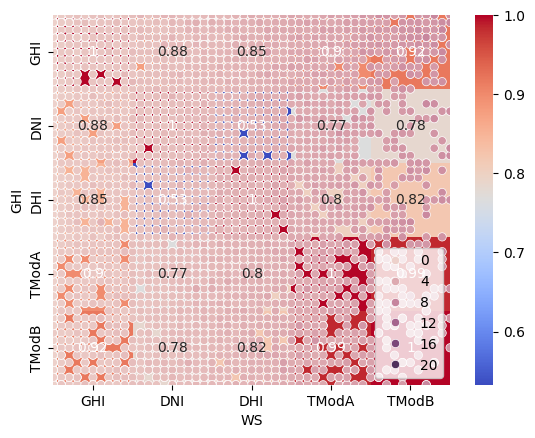

In [9]:
import seaborn as sns
sns.heatmap(df[["GHI","DNI","DHI","TModA","TModB"]].corr(), annot=True, cmap="coolwarm")

sns.scatterplot(data=df, x="WS", y="GHI", hue="WSgust")
sns.scatterplot(data=df, x="RH", y="Tamb")


## Wind & Distribution Analysis

<Axes: xlabel='GHI', ylabel='Count'>

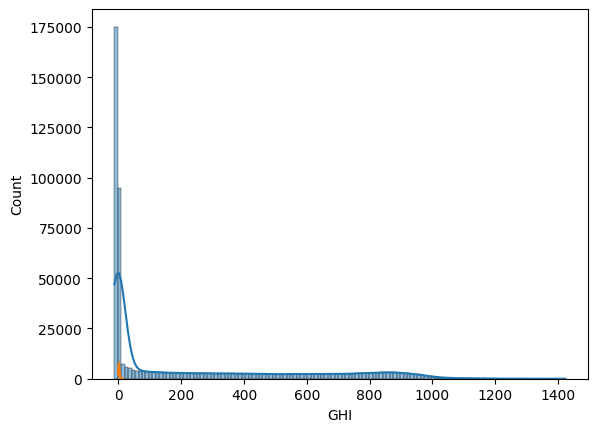

In [10]:
sns.histplot(df["GHI"], kde=True)
sns.histplot(df["WS"], kde=True)


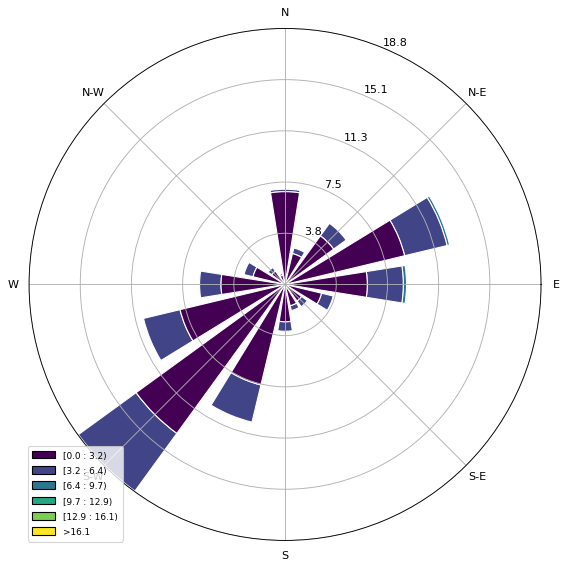

In [11]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

ax = WindroseAxes.from_ax()
ax.bar(df["WD"], df["WS"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend()
plt.show()


## Temperature & Bubble Chart

Text(0.5, 1.0, 'Bubble Chart: GHI vs Tamb with RH/BP')

c:\Users\mihre\Documents\Projects\solar-challenge-week0\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\mihre\Documents\Projects\solar-challenge-week0\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


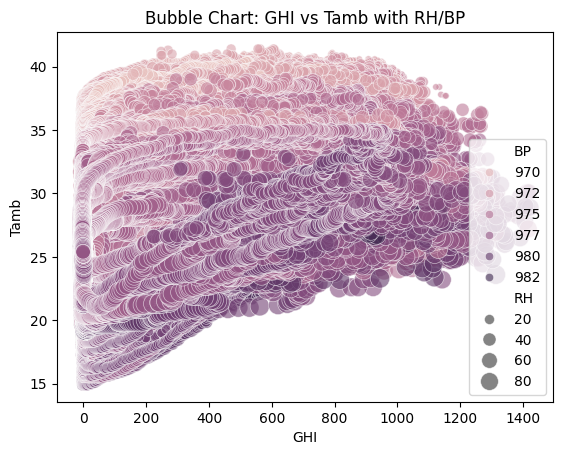

In [12]:
sns.scatterplot(data=df, x="GHI", y="Tamb", size="RH", hue="BP", sizes=(20,200), alpha=0.6)
plt.title("Bubble Chart: GHI vs Tamb with RH/BP")


## Save Cleaned Data

In [13]:
df_clean.to_csv("../data/togo_clean.csv", index=False)
